In [0]:
from fastai.text import * 
from fastai import * 


**[1][Regularizing RNNs by Stabilizing Activations](https://arxiv.org/abs/1511.08400)**
 - by David Krueger, Roland Memisevic



In [4]:

bs=48
path = untar_data(URLs.IMDB)
path.ls()
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch()

idx,text
0,"takes the original point of it away and just renders it nearly unwatchable . ( one joke about xxmaj garth 's eyes xxunk the audience was good ... the rest i can hardly remember ... ) it feels like a poor quality "" xxmaj knowing xxmaj me , xxmaj knowing xxmaj you . "" i hope this improves as the series goes on , otherwise i shall be seriously disappointed"
1,"just started walking out during the course of the screening . \n \n xxmaj there 's no way to actually summarize the story into something coherent , so i wo nt even try . xxmaj every cliché ever conceived is in there , and in all the wrong places . i 'm sorry to say this is one of the worst movies i have ever seen in my entire"
2,"\n \n i must say that , when i first saw this thing on cable , i could n't stop laughing . xxmaj no xxup scifi film had prepared me for this ; it was so incredibly pathetic i could n't believe it ! xxmaj the actors are all a bunch of stereotypical - genre characters . xxmaj but since they 're not so famous ( to say the"
3,"the movie . xxmaj in the film , the characters and set were just some of the let downs that occurred in the movie . xxmaj the director left out so many important and interesting aspects of the book that made it one of the best literary works ever made . \n \n xxmaj of course any book is better than the movie but these were n't even comparable"
4,"the xxmaj berlin xxmaj film xxmaj festival and had medium - high expectations . - xxmaj the director is xxmaj bertrand xxmaj tavernier and i was familiar with some of his previous work in xxmaj french cinema . i actually enjoyed some of his earlier movies . -the cast : xxmaj tommy xxmaj lee xxmaj jones , xxmaj john xxmaj goodman , xxmaj peter xxmaj xxunk , xxmaj mary xxmaj"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
# learn.lr_find()
# learn.recorder.plot(skip_end=15)

In [0]:
learn.save_encoder('fine_tuned_enc')

In [7]:
path = untar_data(URLs.IMDB)
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj by 1987 xxmaj hong xxmaj kong had given the world such films as xxmaj sammo xxmaj hung 's ` xxmaj encounters of the xxmaj spooky xxmaj kind ' xxmaj chow xxmaj yun xxmaj fat in xxmaj john xxmaj woo 's iconic ` a xxmaj better xxmaj tomorrow ' , ` xxmaj zu xxmaj warriors ' and the classic ` xxmaj mr xxmaj vampire ' . xxmaj jackie xxmaj",pos
"xxbos xxmaj god ! xxmaj zorro has been the the subject of about as many movies as xxmaj tarzan , and probably had about as many actors in the title role . \n \n xxmaj this xxmaj serial is one of my own personal favourites , and as previously stated , it is one of the xxmaj top 5 xxmaj sound xxmaj serials . xxmaj oddly enough , this",pos
"xxbos "" a xxmaj damsel in xxmaj distress "" is definitely not one of xxmaj fred xxmaj astaire 's better musicals . xxmaj but even xxmaj astaire 's bad films always had some good moments . \n \n xxmaj in "" xxmaj damsel , "" xxmaj astaire is xxmaj jerry xxmaj halliday , an xxmaj american musical star who is in xxmaj london on a personal appearance tour .",neg
"xxbos xxup warning : xxup possible xxup spoilers ( but not really - keep reading ) . xxmaj ahhh , there are so many reasons to become utterly addicted to this spoof gem that i wo n't have room to list them all . xxmaj the opening credits set the playful scene with kitsch late 1950s cartoon stills ; an enchanting xxmaj xxunk ' xxmaj prez ' xxmaj prado mambo",pos


First using fastai's basic methodology we've created a language model fine tuned on the Wikipedia text. After that we've established a baseline using the fastai's fit_one_cycle policy. 

In [39]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
# learn.lr_find()
# learn.recorder.plot()
learn.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.471733,0.457118,0.777040,10:06
1,0.467318,0.395980,0.822320,10:52
2,0.451140,0.377374,0.832560,09:49
3,0.449924,0.371972,0.836440,10:39
4,0.438636,0.360387,0.843320,11:00



#### **BASELINE** ####
The baseline I have established does not include fine tuning the language model on the IMDB data. I simply loaded the encoder without fine tuning the language model at all. 


#### **fastai's existing fine tuning techniques** ####
fastai already uses a couple of techniques for stabilizing RNNs. 
Those are defined [here](https://github.com/fastai/fastai/blob/master/fastai/callbacks/rnn.py). 

fastai documentation for the fine tuning techniques for `fastai.text` can  be found [here](https://docs.fast.ai/callbacks.rnn.html): 

These techniques are adopted from this paper:

**[2][Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182)**
 - Stephen Merity, Nitish Shirish Keskar, Richard Socher

**[2]** Introduces a technique called `Temporal Activation Regularization (TAR)`

 The TAR technique is essentially adding the following term to the loss (thus it exists in the callback `backward_begin`): 

 `extra_loss_regularization_term = β L2(ht − ht+1)`

 Where `ht` is the hidden state at timestep `t`

For those who are confused by the fancy terms (as I was) [here](https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm) is the definition if L2

 [2] also states:
`As in Merity et al. (2017),
the AR and TAR loss are only applied to the output of the
final RNN layer as opposed to being applied to all layers.`

The Norm Stabilizer paper introduces a technique similar to TAR from the paper above. So it implement this paper we will have to override the existing callback. 

Below is the callback implemented by fastai for reference. 



In [0]:
class RNNTrainer(LearnerCallback):
    "`Callback` that regroups lr adjustment to seq_len, AR and TAR."
    def __init__(self, learn:Learner, alpha:float=0., beta:float=0.):
        super().__init__(learn)
        self.not_min += ['raw_out', 'out']
        self.alpha,self.beta = alpha,beta
        
    def on_epoch_begin(self, **kwargs):
        "Reset the hidden state of the model."
        self.learn.model.reset()

    def on_loss_begin(self, last_output:Tuple[Tensor,Tensor,Tensor], **kwargs):
        "Save the extra outputs for later and only returns the true output."
        self.raw_out,self.out = last_output[1],last_output[2]
        return {'last_output': last_output[0]}

    def on_backward_begin(self, last_loss:Rank0Tensor, last_input:Tensor, **kwargs):
        "Apply AR and TAR to `last_loss`."
        
        #AR 
        if self.alpha != 0.:  last_loss += self.alpha * self.out[-1].float().pow(2).mean()


        # TAR
        if self.beta != 0.:
            h = self.raw_out[-1]
            if len(h)>1: last_loss += self.beta * (h[:,1:] - h[:,:-1]).float().pow(2).mean() #L2


        return {'last_loss': last_loss}


####**Modifications**####

We are going to have to replace the existing callback with a callback which also adds the norm-stabilizer term. 

####**Norm Stabilizer**####
The term reccomended by [1] is as follows: 
`(β/T)* SIGMA[Across T](L2(ht) - L2(ht-1)^2`

I have modified the RNNTrainer to add the norm-stabilizer below. 


In [0]:
def apply_ar(alpha,out): return alpha * out[-1].float().pow(2).mean()

def apply_tar(beta,h): return beta * (h[:,1:] - h[:,:-1]).float().pow(2).mean()

def apply_normstable(beta,h): return beta/h.shape[1] *  (h[:,1:].pow(2).sum().sqrt() - h[:,:-1].pow(2).sum().sqrt()).float().pow(2)

class RNNTrainerNorm(LearnerCallback):
    def __init__(self, learn:Learner, alpha:float=2., beta:float=1., beta_norm:float=50.):
        super().__init__(learn)
        self.not_min += ['raw_out', 'out']
        self.alpha,self.beta,self.beta_norm = alpha,beta,beta_norm
        
    def on_epoch_begin(self, **kwargs):
        "Reset the hidden state of the model."
        self.learn.model.reset()

    def on_loss_begin(self, last_output:Tuple[Tensor,Tensor,Tensor], **kwargs):
        "Save the extra outputs for later and only returns the true output."
        self.raw_out,self.out = last_output[1],last_output[2]
        return {'last_output': last_output[0]}

    def on_backward_begin(self, last_loss:Rank0Tensor, last_input:Tensor, **kwargs):
        "Apply AR and TAR to `last_loss`."
        #AR and TAR
        if self.alpha != 0.:  last_loss += apply_ar(self.alpha,self.out)
        if self.beta != 0.:
            h = self.raw_out[-1]
            if len(h)>1: last_loss += apply_tar(self.beta,h)

        if self.beta_norm != 0.:
            h = self.raw_out[-1]
            if len(h)>1: last_loss += apply_normstable(self.beta_norm,h)        
        
        return {'last_loss': last_loss}



Here are the observations of a small experiment I did. 
[1] and [2] both provide terms which are supposed to stabilize the LSTMs in the `learn.model`. In Jeremy's lectures he points out that when using the `fit_one_cycle` training policy we only train the last layer. 

`learn.model` is made of a `MultiBatchEncoder` with an `AWD_LSTM` inside it and a `PoolingLinearClassifier`. 

I have shown below that the `PoolingLinearClassifier` layer has `requires_grad` set to `True`. So we have a term which is supposed to be affecting the RNNs but since `requires_grad` is set to `False` that can't happen. We should be setting `freeze_to(-2)`

This unfreezes only the last `LSTM` (for which we have added the regularization term) and should give us better results. 


In [40]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(60000, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(60000, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, 

In [0]:
def has_params(m:nn.Module)->bool:
    "Check if `m` has at least one parameter"
    return len(list(m.parameters())) > 0


In [0]:
modules = [m for m in flatten_model(learn.model) if has_params(m)]

In [22]:
modules

[Embedding(60000, 400, padding_idx=1),
 Embedding(60000, 400, padding_idx=1),
 LSTM(400, 1152, batch_first=True),
 ParameterModule(),
 LSTM(1152, 1152, batch_first=True),
 ParameterModule(),
 LSTM(1152, 400, batch_first=True),
 ParameterModule(),
 BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=1200, out_features=50, bias=True),
 BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=50, out_features=2, bias=True)]

In [0]:
def requires_grad_bool(m:nn.Module)->Optional[bool]:
    ps = list(m.parameters())
    return ps[0].requires_grad


In [30]:
for it in modules:
  print(requires_grad_bool(it),it)

False Embedding(60000, 400, padding_idx=1)
False Embedding(60000, 400, padding_idx=1)
False LSTM(400, 1152, batch_first=True)
False ParameterModule()
False LSTM(1152, 1152, batch_first=True)
False ParameterModule()
False LSTM(1152, 400, batch_first=True)
False ParameterModule()
True BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True Linear(in_features=1200, out_features=50, bias=True)
True BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True Linear(in_features=50, out_features=2, bias=True)


In [0]:
learn.freeze_to(-2)

In [0]:
modules = [m for m in flatten_model(learn.model) if has_params(m)]

In [33]:
for it in modules:
  print(requires_grad_bool(it),it)

False Embedding(60000, 400, padding_idx=1)
False Embedding(60000, 400, padding_idx=1)
False LSTM(400, 1152, batch_first=True)
False ParameterModule()
False LSTM(1152, 1152, batch_first=True)
False ParameterModule()
True LSTM(1152, 400, batch_first=True)
True ParameterModule()
True BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True Linear(in_features=1200, out_features=50, bias=True)
True BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True Linear(in_features=50, out_features=2, bias=True)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


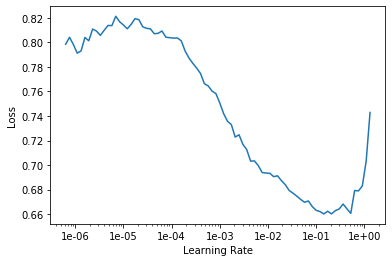

In [37]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.445050,0.361552,0.842000,10:25
1,0.443763,0.360960,0.845600,10:24
2,0.427118,0.358420,0.843040,10:15
3,0.447346,0.355710,0.844480,11:09
4,0.437228,0.361192,0.842680,10:53


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


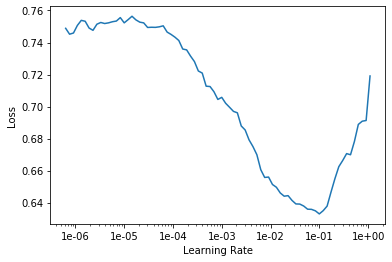

In [56]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,)
learn = learn.load_encoder('fine_tuned_enc')
learn.freeze_to(-2)
learn.callbacks =[RNNTrainerNorm(learn,2.,0.,500.)]
learn.lr_find()
learn.recorder.plot()

In [57]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.424120,0.399041,0.815960,12:43
1,0.362391,0.291880,0.880840,12:27
2,0.312827,0.259725,0.892560,11:26
3,0.279835,0.236507,0.904760,12:35
4,0.271583,0.236181,0.906480,12:50
